In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from utils import ffmpeg_load_audio, list_all_files
from multiprocessing import Pool
from librosa.feature import rmse, spectral_centroid, spectral_rolloff, spectral_bandwidth, chroma_cqt
import librosa
import numpy as np

In [2]:
def get_stats(y, sr, hop_length=256):
    results = {}
    S, phase = librosa.magphase(librosa.stft(y=y, n_fft=2048, hop_length=hop_length))
    env = np.array(rmse(S=S).reshape(-1))
    peak = env.argmax()
    cs = np.cumsum(env)
    cs /= cs.max()
    return {
        'peak': hop_length * peak,
        'percentiles': [
            hop_length * (np.searchsorted(cs, 0.1) - peak),
            hop_length * (np.searchsorted(cs, 0.5) - peak),
            hop_length * (np.searchsorted(cs, 0.9) - peak)
        ],
        'power': env.sum(),
        'centroid': spectral_centroid(S=S)[0,peak],
        'rolloff': spectral_rolloff(S=S)[0,peak],
        'bandwidth': spectral_bandwidth(S=S)[0,peak],
        'chroma': chroma_cqt(y=y, sr=sr, hop_length=hop_length, tuning=0)[:,peak]
    }

In [6]:
# this is how you run it from a .npy file
sr=44100
%time samples = np.load('input/28k/samples.npy')
def get_stats_closure(y):
    return get_stats(y, sr)
p = Pool(4)
%time results = p.map(get_stats_closure, samples)

CPU times: user 768 µs, sys: 4.66 s, total: 4.66 s
Wall time: 6.95 s


In [4]:
# this is how you run it from a directory of files
sr=44100
files = list(list_all_files('data/birds', ['.wav']))
def get_stats_closure(fn):
    y, sr = ffmpeg_load_audio(fn, normalize=False, mono=True) # assume already normalized
    return get_stats(y, sr)
p = Pool(4)
%time results = p.map(get_stats_closure, files)

CPU times: user 64.7 ms, sys: 16.8 ms, total: 81.6 ms
Wall time: 49.6 s


In [5]:
results[0]

{'bandwidth': 1198.9934180901571,
 'centroid': 1275.057714079906,
 'chroma': array([ 0.09369462,  1.        ,  0.02101784,  0.00818331,  0.00295739,
         0.00928702,  0.00743891,  0.00933379,  0.07434571,  0.00716813,
         0.00708397,  0.01049693]),
 'peak': 46080,
 'percentiles': [-3072, 8192, 24576],
 'power': 1180.8213,
 'rolloff': 1981.0546875}

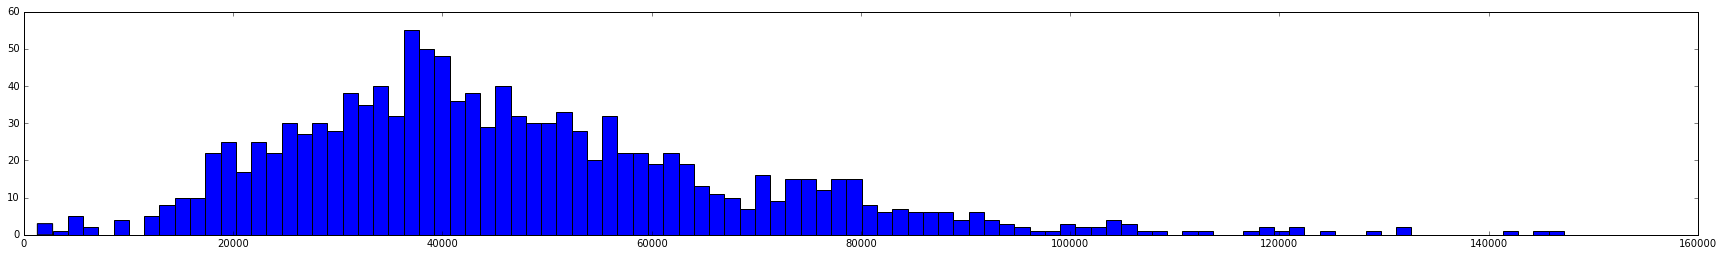

In [6]:
plt.figure(figsize=(30,4))
plt.hist([x['peak'] for x in results], bins=100)
plt.show()

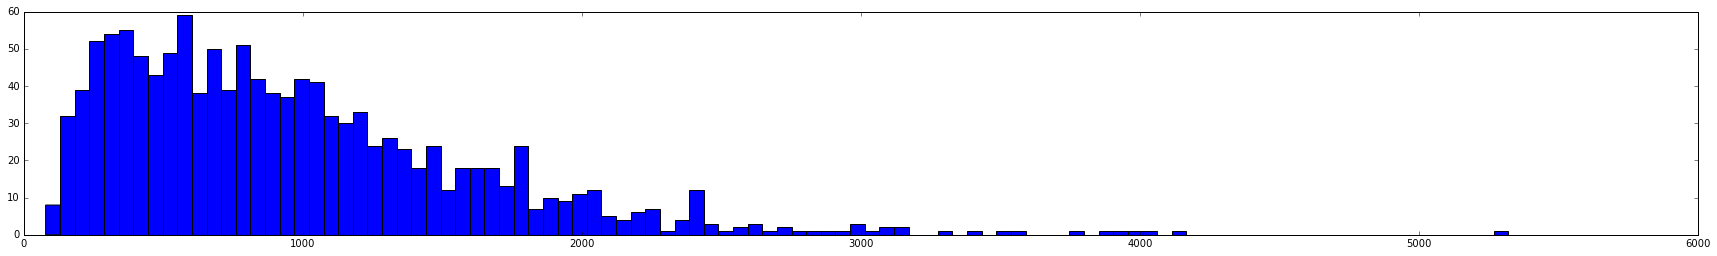

In [7]:
plt.figure(figsize=(30,4))
plt.hist([x['power'] for x in results], bins=100)
plt.show()

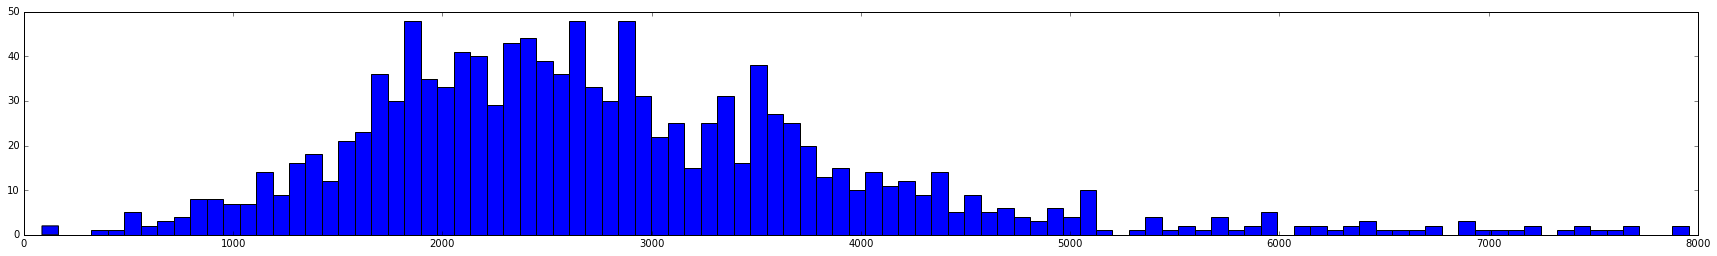

In [8]:
plt.figure(figsize=(30,4))
plt.hist([x['rolloff'] for x in results], bins=100)
plt.show()

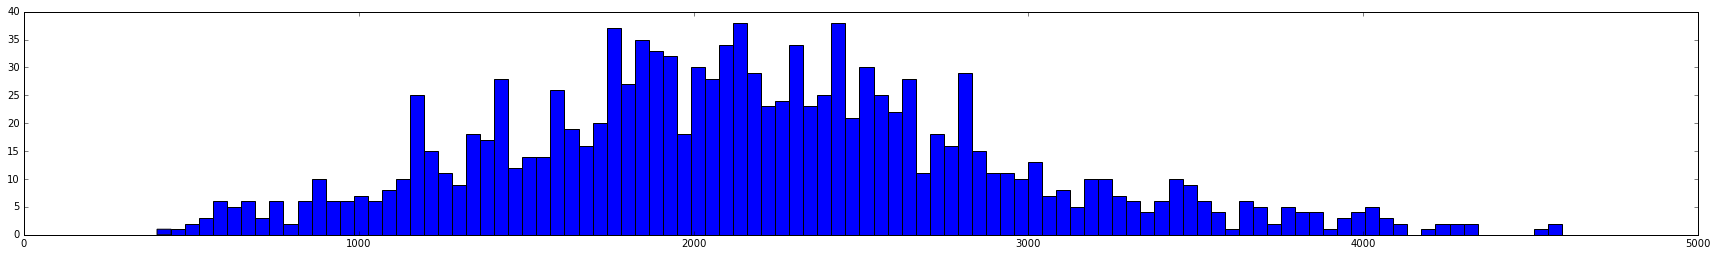

In [9]:
plt.figure(figsize=(30,4))
plt.hist([x['centroid'] for x in results], bins=100)
plt.show()

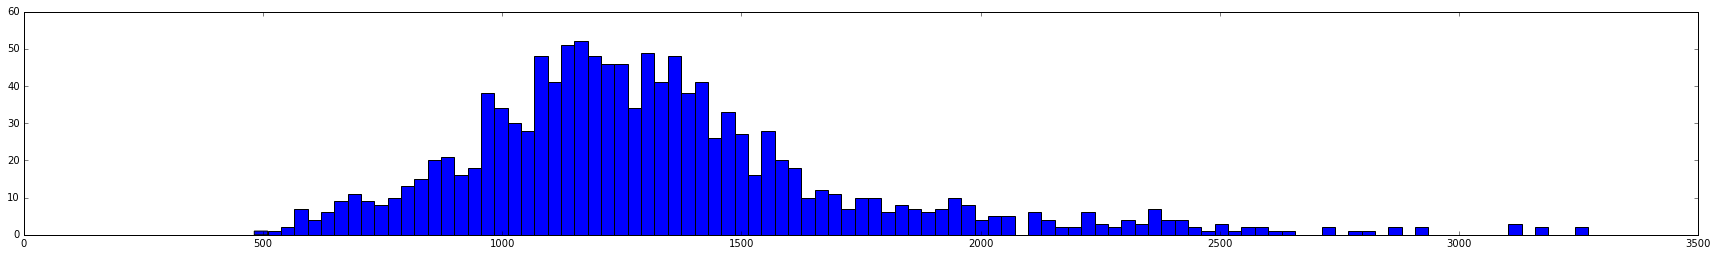

In [10]:
plt.figure(figsize=(30,4))
plt.hist([x['bandwidth'] for x in results], bins=100)
plt.show()

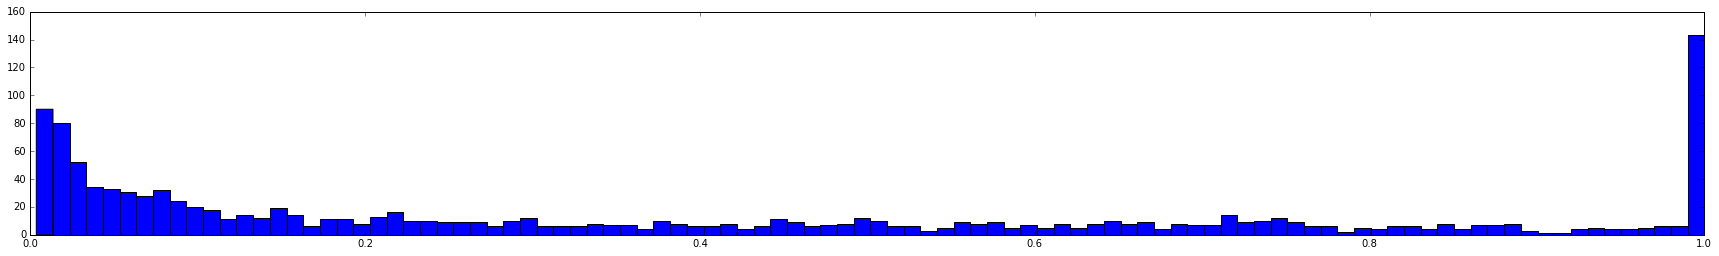

In [11]:
plt.figure(figsize=(30,4))
plt.hist([x['chroma'][10] for x in results], bins=100)
plt.show()

In [12]:
import cPickle as pickle
with open('results.pkl', 'w') as f:
    pickle.dump(results, f)